# LOADING LIBRARIES

In [2]:
import json
import sys
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=4)
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# DATASET
## 2nd derivative

In [3]:
# TAKE THE DATA FROM JSON
with open('../Simulation/data_pos_sim_labelled_sep_motion.json') as f:
    data_dict = json.load(f)

data_list = [data_dict['LF_motion1'],data_dict['RF_motion1']]
data_array = np.array(data_list).T
temp_data_array = np.append(data_array[np.newaxis,0,:,0],data_array[np.newaxis,0,:,1],axis=0)
data_array = np.append(temp_data_array,data_array[np.newaxis,1,:,1],axis=0).T
angle_array = data_array[:,:2].astype(float)

# 1st derivative
# we only keep the value of the right finger because it is the follower
gradient = []
for i in range(angle_array.shape[0]-1):
    rate_change = angle_array.T[1][i+1]-angle_array.T[1][i]
    gradient += [round(rate_change,3)]

# 2nd derivative
double_gradient = []
for i in range(len(gradient)-1):
    rate_change = gradient[i+1]-gradient[i]
    double_gradient += [round(rate_change,3)]

# we need to set up a min double gradient to identify the corners
threshold = 0.1
identified_corners = []
for i in range(len(double_gradient)):
    if abs(double_gradient[i]) > threshold:
        identified_corners += [angle_array[i].tolist()]
identified_corners = np.array(identified_corners)

## windowing to analyse performance

In [4]:
# TAKE THE DATA FROM JSON --> pose = 65 ; gap = 50 ; dim = 50
with open('../Simulation/data_pos_sim_labelled_sep_motion.json') as f:
    data_dict = json.load(f)

data_list = [data_dict['LF_motion1'],data_dict['RF_motion1']]
data_array = np.array(data_list).T
temp_data_array = np.append(data_array[np.newaxis,0,:,0],data_array[np.newaxis,0,:,1],axis=0)
data_array = np.append(temp_data_array,data_array[np.newaxis,1,:,1],axis=0).T
angle_array = data_array[:,:2].astype(float)

# CREATE A DATAFRAME BY WINDOWING THE RAW AND INCREMENTING THE POSITION OF THE WINDOW
rows,columns = data_array.shape
window_size = 5 # needs to be odd
half_window_size = math.floor(window_size/2)
data_window = np.zeros((rows-half_window_size*2,window_size*2+1)) #+1 for the class
corners = []
sides = []

for i in range(half_window_size,rows-half_window_size):
    temp_window = np.append(data_array[i-half_window_size:half_window_size+i+1,:].T[0],
                            data_array[i-half_window_size:half_window_size+i+1,:].T[1])
    if 'corner' in data_array[i-half_window_size+1:half_window_size+i+1-1,:].T[2]:
        # CLASS 2 IS THE CORNER
        corners += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([2]))
    else :
        # CLASS 1 IS THE SIDE
        sides += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([1]))

#print(data_window)
names = []
for j in range(window_size):
    names += ["angleLF"+str(j+1)]
for j in range(window_size):
    names += ["angleRF"+str(j+1)]
names += ["class"]

# DATA FRAME PANDAS
df = pd.DataFrame(data=data_window,columns = names)
df["class"].replace({1.0: "side", 2.0: "corner"}, inplace=True)
df.dropna(how='all', inplace=True)
windows = df[names[:len(names)-1]]
labels = df[names[-1]]

corners_pos = np.array(corners)
sides_pos = np.array(sides)

df.head()
#windows.head()
#labels.head()

,angleLF1,angleLF2,angleLF3,angleLF4,angleLF5,angleRF1,angleRF2,angleRF3,angleRF4,angleRF5,class
0,40.0,41.0,42.0,43.0,44.0,38.216855,39.705104,41.189086,42.669395,44.146616,side
1,41.0,42.0,43.0,44.0,45.0,39.705104,41.189086,42.669395,44.146616,45.621328,side
2,42.0,43.0,44.0,45.0,46.0,41.189086,42.669395,44.146616,45.621328,47.094103,side
3,43.0,44.0,45.0,46.0,47.0,42.669395,44.146616,45.621328,47.094103,48.565513,side
4,44.0,45.0,46.0,47.0,48.0,44.146616,45.621328,47.094103,48.565513,50.036130,side


# PLOT THE IDENTIFIED CORNERS

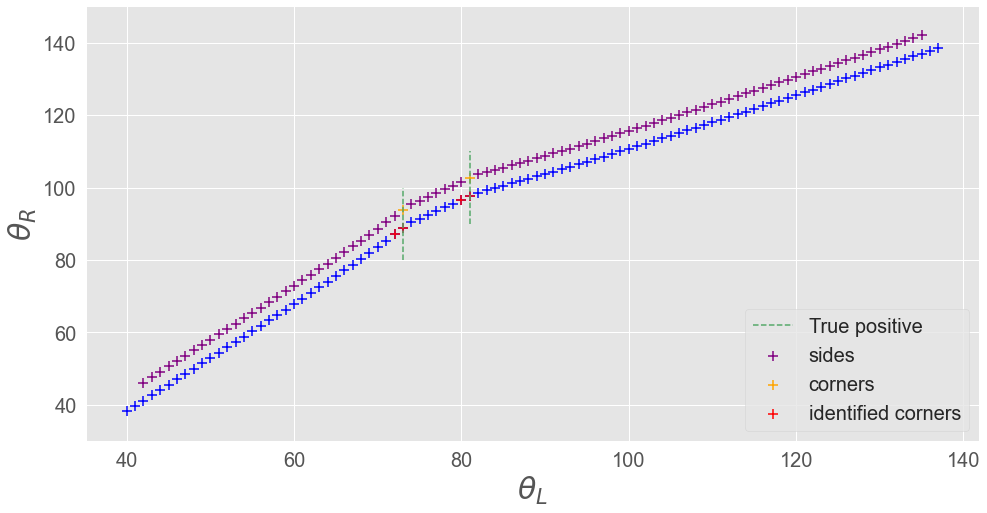

In [12]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(sides_pos.T[0],sides_pos.T[1]+5,s=100,color='purple',marker='+',label='sides')
plt.scatter(corners_pos.T[0][1],corners_pos.T[1][1]+5,s=100,color='orange',marker='+',label='corners')
plt.scatter(corners_pos.T[0][4],corners_pos.T[1][4]+5,s=100,color='orange',marker='+')
plt.scatter(corners_pos.T[0][0],corners_pos.T[1][0]+5,s=100,color='purple',marker='+')
plt.scatter(corners_pos.T[0][2:4],corners_pos.T[1][2:4]+5,s=100,color='purple',marker='+')
plt.scatter(corners_pos.T[0][5],corners_pos.T[1][5]+5,s=100,color='purple',marker='+')
plt.scatter(angle_array.T[0], angle_array.T[1],s=100, color='blue',marker='+')
plt.scatter(identified_corners.T[0],identified_corners.T[1],s=100,
            color='red',marker='+',label='identified corners')
plt.plot([identified_corners.T[0][1],identified_corners.T[0][1]],[80,100],'--',color='g',label='True positive')
plt.plot([identified_corners.T[0][3],identified_corners.T[0][3]],[90,110],'--',color='g')
#plt.plot([identified_corners.T[0][0],identified_corners.T[0][0]],[80,100],'--',color='g')
#plt.plot([identified_corners.T[0][2],identified_corners.T[0][2]],[90,110],'--',color='g')
plt.ylabel(r'$\theta_R$')
plt.xlabel(r'$\theta_L$')
plt.legend(loc='lower right')
plt.ylim(30,150)
plt.savefig("corner_id_snd_deriv_1sqr_sim.png")

f1-score = 0.8

### compute f1-score automatically

In [42]:
nb_corner = corners_pos.shape[0]
nb_corner_id = identified_corners.shape[0]
precision = nb_corner_id/nb_corner
recall = 1
f1 = 2/(1/precision+1/recall)
print(f1)

[[72.     87.113 ]
 [73.     88.8908]
 [74.     90.3903]
 [80.     96.603 ]
 [81.     97.6769]
 [82.     98.6256]]
0.6666666666666666
0.8


# Complete the data set

In [17]:
# CREATE A DATAFRAME BY WINDOWING THE RAW AND INCREMENTING THE POSITION OF THE WINDOW
rows,columns = data_array.shape
window_size = 5 # needs to be odd
half_window_size = math.floor(window_size/2)
data_window = np.zeros((rows-half_window_size*2,window_size*2+3)) #+3 for 1st/2nd deriv and the class
corners = []
sides = []

for i in range(half_window_size,rows-half_window_size):
    temp_window = np.append(data_array[i-half_window_size:half_window_size+i+1,:].T[0],
                            data_array[i-half_window_size:half_window_size+i+1,:].T[1])
    temp_window = np.append(temp_window, np.array([gradient[i],double_gradient[i]]))
    if 'corner' in data_array[i-half_window_size:half_window_size+i+1,:].T[2]:
        # CLASS 2 IS THE CORNER
        corners += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([2]))
    else :
        # CLASS 1 IS THE SIDE
        sides += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([1]))

#print(data_window)
names = []
for j in range(window_size):
    names += ["angleLF"+str(j+1)]
for j in range(window_size):
    names += ["angleRF"+str(j+1)]
names += ["1st derivative","2nd derivative","class"]

# DATA FRAME PANDAS
df = pd.DataFrame(data=data_window,columns = names)
df["class"].replace({1.0: "side", 2.0: "corner"}, inplace=True)
df.dropna(how='all', inplace=True)
windows = df[names[:len(names)-1]]
labels = df[names[-1]]

corners_pos = np.array(corners)
sides_pos = np.array(sides)

df.head()
#windows.head()
#labels.head()

,angleLF1,angleLF2,angleLF3,angleLF4,angleLF5,angleRF1,angleRF2,angleRF3,angleRF4,angleRF5,1st derivative,2nd derivative,class
0,40.0,41.0,42.0,43.0,44.0,38.216855,39.705104,41.189086,42.669395,44.146616,1.480,-0.003,side
1,41.0,42.0,43.0,44.0,45.0,39.705104,41.189086,42.669395,44.146616,45.621328,1.477,-0.002,side
2,42.0,43.0,44.0,45.0,46.0,41.189086,42.669395,44.146616,45.621328,47.094103,1.475,-0.002,side
3,43.0,44.0,45.0,46.0,47.0,42.669395,44.146616,45.621328,47.094103,48.565513,1.473,-0.002,side
4,44.0,45.0,46.0,47.0,48.0,44.146616,45.621328,47.094103,48.565513,50.036130,1.471,0.000,side


# LDA with sklearn

In [18]:
# Preparation of the data for LDA
# Standardizing data
X = df.iloc[:, 0:-1].values
le = LabelEncoder()
y = le.fit_transform(df['class'])
print("After formating the data we have: \n X = \n",X[:5],'\n y = \n', y)

# Import LDA from sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda_X = lda.fit_transform(X, y)
print("The explained variance ratio of lda is : ", lda.explained_variance_ratio_)

After formating the data we have: 
 X = 
 [[ 4.0000e+01  4.1000e+01  4.2000e+01  4.3000e+01  4.4000e+01  3.8217e+01
   3.9705e+01  4.1189e+01  4.2669e+01  4.4147e+01  1.4800e+00 -3.0000e-03]
 [ 4.1000e+01  4.2000e+01  4.3000e+01  4.4000e+01  4.5000e+01  3.9705e+01
   4.1189e+01  4.2669e+01  4.4147e+01  4.5621e+01  1.4770e+00 -2.0000e-03]
 [ 4.2000e+01  4.3000e+01  4.4000e+01  4.5000e+01  4.6000e+01  4.1189e+01
   4.2669e+01  4.4147e+01  4.5621e+01  4.7094e+01  1.4750e+00 -2.0000e-03]
 [ 4.3000e+01  4.4000e+01  4.5000e+01  4.6000e+01  4.7000e+01  4.2669e+01
   4.4147e+01  4.5621e+01  4.7094e+01  4.8566e+01  1.4730e+00 -2.0000e-03]
 [ 4.4000e+01  4.5000e+01  4.6000e+01  4.7000e+01  4.8000e+01  4.4147e+01
   4.5621e+01  4.7094e+01  4.8566e+01  5.0036e+01  1.4710e+00  0.0000e+00]] 
 y = 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
The explaine

In [ ]:
# Plot projection on feature vectors

# Plotting functions

## Plot the positions of the finger

In [ ]:
def plot_pos_fingers(sides_pos,corners_pos,dim,pose,gap):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 30

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig, ax = plt.subplots()
    plt.style.use("ggplot")
    plt.rcParams["figure.figsize"] = (12,8)
    plt.scatter(sides_pos.T[0],sides_pos.T[1],color='b',marker='+',label='sides')
    plt.scatter(corners_pos.T[0],corners_pos.T[1],color='r',marker='+',label='corners')
    plt.ylabel(r'$\theta_R$')
    plt.xlabel(r'$\theta_L$')
    plt.legend(loc='lower right')
    plt.title("Raw data: dim="+str(dim)+'x'+str(dim)+ 'mm ; pose='+str(pose)+'mm ; gap='+str(gap)+'mm',fontsize=20)
    #plt.savefig('raw_data_dim'+str(dim)+'x'+str(dim)+ '_pose_'+str(pose)+'_gap_'+str(gap)+'.png')

## Plot projection on feature vectors

In [ ]:
def plot_proj_ld1(lda_X,y,dim,pose,gap):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 30

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig, ax = plt.subplots()
    plt.style.use("ggplot")
    plt.rcParams["figure.figsize"] = (12,8)
    ax.axes.yaxis.set_ticks([])
    plt.ylabel('LD1')
    plt.scatter(lda_X[y==0], np.full((len(lda_X[y==0]),),1.0), s=100, color='b', label='corner')
    plt.scatter(lda_X[y==1], np.full((len(lda_X[y==1]),),1.0), s=100, color='r', label='side')
    plt.plot([-1.4,-1.4],[0.9,1.1],'--',color='g')
    plt.ylim(0.9,1.1)
    ax.legend()
    plt.title("1D LDA: dim="+str(dim)+'x'+str(dim)+ 'mm ; pose='+str(pose)+'mm ; gap='+str(gap)+'mm',fontsize=20)
    #plt.savefig('1D_LDA_proj_dim'+str(dim)+'x'+str(dim)+ '_pose_'+str(pose)+'_gap_'+str(gap)+'.png')

## 2-means

In [ ]:
def plot_ld1_2means(lda_X,y,y_k2means,dim,pose,gap):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 30

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig, ax = plt.subplots()
    plt.style.use("ggplot")
    plt.rcParams["figure.figsize"] = (12,8)
    ax.axes.yaxis.set_ticks([])
    plt.ylabel('LD1 & 2-means clustering')
    plt.scatter(lda_X[y==0], np.full((len(lda_X[y==0]),),2), color='orange', label='corner')
    plt.scatter(lda_X[y==1], np.full((len(lda_X[y==1]),),2), color='purple', label='side')
    plt.scatter(lda_X[y_k2means==0], np.full((len(lda_X[y_k2means==0]),),1.0), c='red', label ='Cluster 1')
    plt.scatter(lda_X[y_k2means==1], np.full((len(lda_X[y_k2means==1]),),1.0), c='blue', label ='Cluster 2')
    plt.scatter(k2means.cluster_centers_[:, 0], np.full((len(k2means.cluster_centers_[:, 0]),),1.0),
                s=100, c='yellow', marker='x',label = 'Centroids')
    plt.plot([-1.4,-1.4],[0,4],'--',color='g')
    plt.ylim(0,4)
    ax.legend()
    plt.title("LD1 & 2-means: dim="+str(dim)+'x'+str(dim)+ 'mm ; pose='+str(pose)+'mm ; gap='+str(gap)+'mm',fontsize=20)
    #plt.savefig('LD1_2_means_dim'+str(dim)+'x'+str(dim)+ '_pose_'+str(pose)+'_gap_'+str(gap)+'.png')
    #Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.

    ##########################################################################################

def plot_raw_2means(sides_pos,corners_pos,angle_array,half_window_size,y_k2means,dim,pose,gap):
    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    fig, ax = plt.subplots()
    plt.style.use("ggplot")
    plt.rcParams["figure.figsize"] = (12,8)
    plt.scatter(sides_pos.T[0],sides_pos.T[1]+5,color='purple',marker='+',label='sides')
    plt.scatter(corners_pos.T[0],corners_pos.T[1]+5,color='orange',marker='+',label='corners')
    plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k2means == 0],
                angle_array[half_window_size:-half_window_size].T[1][y_k2means == 0]-5,
                marker='+', c='red', label ='Cluster 1')
    plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k2means == 1],
                angle_array[half_window_size:-half_window_size].T[1][y_k2means == 1]-5,
                marker='+', c='blue', label ='Cluster 2')
    plt.plot(angle_array[half_window_size:-half_window_size].T[0],
             angle_array[half_window_size:-half_window_size].T[1],
             color='yellow', label='raw data')
    plt.ylabel(r'$\theta_R$')
    plt.xlabel(r'$\theta_L$')
    plt.legend(loc='lower right')
    plt.title("raw data processed (2-means): dim="+str(dim)+'x'+str(dim)+ 'mm ; pose='+str(pose)+'mm ; gap='+str(gap)+'mm',fontsize=20)
    #plt.savefig('clusters_class_raw_2_means_dim'+str(dim)+'x'+str(dim)+ '_pose_'+str(pose)+'_gap_'+str(gap)+'.png')

## 3-means

In [ ]:
def plot_ld1_3means(lda_X,y,y_k3means,dim,pose,gap):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 30

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig, ax = plt.subplots()
    plt.style.use("ggplot")
    plt.rcParams["figure.figsize"] = (12,8)
    ax.axes.yaxis.set_ticks([])
    plt.ylabel('LD1 & 3-means clustering')
    plt.scatter(lda_X[y==0], np.full((len(lda_X[y==0]),),2), color='orange', label='corner')
    plt.scatter(lda_X[y==1], np.full((len(lda_X[y==1]),),2), color='purple', label='side')
    plt.scatter(lda_X[y_k3means==0], np.full((len(lda_X[y_k3means==0]),),1.0), c='red', label ='Cluster 1')
    plt.scatter(lda_X[y_k3means==1], np.full((len(lda_X[y_k3means==1]),),1.0), c='blue', label ='Cluster 2')
    plt.scatter(lda_X[y_k3means==2], np.full((len(lda_X[y_k3means==2]),),1.0), c='green', label ='Cluster 3')
    plt.scatter(k3means.cluster_centers_[:, 0], np.full((len(k3means.cluster_centers_[:, 0]),),1.0),
                s=100, c='yellow', marker='x',label = 'Centroids')
    plt.plot([-1.4,-1.4],[0,4],'--',color='g')
    plt.ylim(0,4)
    ax.legend()
    plt.title("LD1 & 3-means: dim="+str(dim)+'x'+str(dim)+ 'mm ; pose='+str(pose)+'mm ; gap='+str(gap)+'mm',fontsize=20)
    #plt.savefig('LD1_3_means_dim'+str(dim)+'x'+str(dim)+ '_pose_'+str(pose)+'_gap_'+str(gap)+'.png')

    ##########################################################################################

def plot_raw_3means(sides_pos,corners_pos,angle_array,half_window_size,y_k3means,dim,pose,gap):
    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes

    fig, ax = plt.subplots()
    plt.style.use("ggplot")
    plt.rcParams["figure.figsize"] = (12,8)
    plt.scatter(sides_pos.T[0],sides_pos.T[1]+5,color='purple',marker='+',label='sides')
    plt.scatter(corners_pos.T[0],corners_pos.T[1]+5,color='orange',marker='+',label='corners')
    plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k3means == 0],
                angle_array[half_window_size:-half_window_size].T[1][y_k3means == 0]-5,
                marker='+', c='red', label ='Cluster 1')
    plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k3means == 1],
                angle_array[half_window_size:-half_window_size].T[1][y_k3means == 1]-5,
                marker='+', c='blue', label ='Cluster 2')
    plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k3means == 2],
                angle_array[half_window_size:-half_window_size].T[1][y_k3means == 2]-5,
                marker='+', c='green', label ='Cluster 3')
    plt.plot(angle_array[half_window_size:-half_window_size].T[0],
             angle_array[half_window_size:-half_window_size].T[1],
             color='yellow', label='raw data')
    plt.ylabel(r'$\theta_R$')
    plt.xlabel(r'$\theta_L$')
    plt.legend(loc='lower right')
    plt.title("raw data processed (3-means): dim="+str(dim)+'x'+str(dim)+ 'mm ; pose='+str(pose)+'mm ; gap='+str(gap)+'mm',fontsize=20)
    #plt.savefig('clusters_class_raw_3_means_dim'+str(dim)+'x'+str(dim)+ '_pose_'+str(pose)+'_gap_'+str(gap)+'.png')

# Dataset

In [112]:
with open('../Simulation/multiple_sqrt_sim_data_pos.json') as f:
    full_data_dict = json.load(f)

poses_drf = [60,65,70]
finger_gaps = [34,42,50]
sqrt_sides = [20,25,30]
f1_scores = {}

for pose in poses_drf:
    for gap in finger_gaps:
        for dim in sqrt_sides:
            dict_key = "dim_"+str(dim)+"_pose_"+str(pose)+"_gap_"+str(gap)
            data_dict = full_data_dict[dict_key]

            data_list = [data_dict['LF_motion1'],data_dict['RF_motion1']]
            data_array = np.array(data_list).T
            temp_data_array = np.append(data_array[np.newaxis,0,:,0],data_array[np.newaxis,0,:,1],axis=0)
            data_array = np.append(temp_data_array,data_array[np.newaxis,1,:,1],axis=0).T
            angle_array = data_array[:,:2].astype(float)
            
            # 1st derivative
            # we only keep the value of the right finger because it is the follower
            gradient = []
            for i in range(angle_array.shape[0]-1):
                rate_change = angle_array.T[1][i+1]-angle_array.T[1][i]
                gradient += [round(rate_change,3)]

            # 2nd derivative
            double_gradient = []
            for i in range(len(gradient)-1):
                rate_change = (gradient[i+1]-gradient[i])*100000 # try to amplify the second derivative
                double_gradient += [round(rate_change,3)]

            # CREATE A DATAFRAME BY WINDOWING THE RAW AND INCREMENTING THE POSITION OF THE WINDOW
            rows,columns = data_array.shape
            window_size = 5 # needs to be odd
            half_window_size = math.floor(window_size/2)
            data_window = np.zeros((rows-half_window_size*2,window_size*2+3)) #+3 for 1st/2nd deriv and the class
            corners = []
            sides = []

            for i in range(half_window_size,rows-half_window_size):
                temp_window = np.append(data_array[i-half_window_size:half_window_size+i+1,:].T[0],
                                        data_array[i-half_window_size:half_window_size+i+1,:].T[1])
                temp_window = np.append(temp_window, np.array([gradient[i],double_gradient[i]]))
                if 'corner' in data_array[i-half_window_size:half_window_size+i+1,:].T[2]:
                    # CLASS 2 IS THE CORNER
                    corners += [angle_array[i].tolist()]
                    data_window[i-half_window_size] = np.append(temp_window,np.array([2]))
                else :
                    # CLASS 1 IS THE SIDE
                    sides += [angle_array[i].tolist()]
                    data_window[i-half_window_size] = np.append(temp_window,np.array([1]))

            #print(data_window)
            names = []
            for j in range(window_size):
                names += ["angleLF"+str(j+1)]
            for j in range(window_size):
                names += ["angleRF"+str(j+1)]
            names += ["1st derivative","2nd derivative","class"]

            # DATA FRAME PANDAS
            df = pd.DataFrame(data=data_window,columns = names)
            df["class"].replace({1.0: "side", 2.0: "corner"}, inplace=True)
            df.dropna(how='all', inplace=True)
            windows = df[names[:len(names)-1]]
            labels = df[names[-1]]

            corners_pos = np.array(corners)
            sides_pos = np.array(sides)

            df.head()

            ##########################################################################################
            ############################# Plot the positions of the finger ###########################
            ##########################################################################################
            #plot_pos_fingers(sides_pos,corners_pos,dim,pose,gap)

            ##########################################################################################
            ############################# LDA with sklearn ###########################
            ##########################################################################################

            # Preparation of the data for LDA
            X = df.iloc[:, 0:-1].values
            le = LabelEncoder()
            y = le.fit_transform(df['class'])

            # Import LDA from sklearn
            lda = LinearDiscriminantAnalysis()
            lda_X = lda.fit_transform(X, y)
            print("The explained variance ratio of lda is : ", lda.explained_variance_ratio_)

            ##########################################################################################
            ############################# Plot projection on feature vectors ###########################
            ##########################################################################################
            #plot_proj_ld1(lda_X,y,dim,pose,gap)

            ##########################################################################################
            #################################### K-means #############################################
            ##########################################################################################

            # 2-means clustering
            k2means = KMeans(n_clusters=2, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
            y_k2means = k2means.fit_predict(lda_X)

            # 3-mens clustering
            k3means = KMeans(n_clusters=3, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
            y_k3means = k3means.fit_predict(lda_X)

            ##########################################################################################
            #plot_ld1_2means(lda_X,y,y_k2means,dim,pose,gap)
            ##########################################################################################
            #plot_raw_2means(sides_pos,corners_pos,angle_array,half_window_size,y_k2means,dim,pose,gap)
            ##########################################################################################
            #plot_ld1_3means(lda_X,y,y_k3means,dim,pose,gap)
            ##########################################################################################
            #plot_raw_3means(sides_pos,corners_pos,angle_array,half_window_size,y_k3means,dim,pose,gap)
            ##########################################################################################

            ##########################################################################################
            #################################### F1-score ############################################
            ##########################################################################################

            # we need to change "y" before beca
            y_true = []
            for i in range(y.shape[0]):
                if y[i] == 0:
                    y_true += [1]
                else:
                    y_true += [0]

            f1_score_2means = f1_score(y_true,y_k2means)
            print("The f1_score of the 2-means is : ",f1_score_2means)
            print(y_true)

            # f1-score on just the corner identification
            y_k3_corner = []
            for i in range(len(y_k3means.tolist())):
                if y_k3means[i] == 2:
                    y_k3_corner += [1]
                else :
                    y_k3_corner += [y_k3means[i]]
            y_k3_corner = np.array(y_k3_corner)

            f1_score_3means = f1_score(y_true,y_k3_corner)
            print("The f1_score of the 3-means for global corner identification is : ",f1_score_3means)

            # f1-score on the number of corners
            u = 0
            v = 0
            y_true_corners = []
            for i in range(len(y_true)):
                if y_true[i] == 1 and v == 0:
                    y_true_corners += [y_true[i]]
                    u = 1
                elif y_true[i] == 0 and u==1:
                    y_true_corners += [y_true[i]]
                    v = 1
                elif y_true[i] == 1 and v==1:
                    y_true_corners += [2]
                else:
                    y_true_corners += [y_true[i]]
            acc_3means = accuracy_score(y_true_corners,y_k3means)
            print("The f1_score of the 3-means for each corner identification (micro/or accuracy) is : ",
                  acc_3means)

            f1_scores[dict_key] = {
                "The f1_score 2-means corner identification" : f1_score_2means,
                "The f1_score 3-means global corner identification" : f1_score_3means,
                "The f1_score 3-means each corner identification" : acc_3means
            }

print(f1_scores)

The explained variance ratio of lda is :  [1.]
The f1_score of the 2-means is :  0.7499999999999999
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The f1_score of the 3-means for global corner identification is :  0.5555555555555556
The f1_score of the 3-means for each corner identification (micro/or accuracy) is :  0.6363636363636364
The explained variance ratio of lda is :  [1.]
The f1_score of the 2-means is :  0.7499999999999999
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The f1_score of the 3-means for global corner identification is :  0.625
The f1_score of the 3-means for each corner identification (micro/or accuracy) is :  0.68
The explained variance ratio of lda is :  [1.]
The f1_score of the 2-means is :  0.923076923076923
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

The f1_score of the 3-means for global corner identification is :  0.19999999999999998
The f1_score of the 3-means for each corner identification (micro/or accuracy) is :  0.13559322033898305
The explained variance ratio of lda is :  [1.]
The f1_score of the 2-means is :  0.8235294117647058
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The f1_score of the 3-means for global corner identification is :  0.7692307692307693
The f1_score of the 3-means for each corner identification (micro/or accuracy) is :  0.7962962962962963
The explained variance ratio of lda is :  [1.]
The f1_score of the 2-means is :  0.7499999999999999
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The f1_score of the 3-means for global corner identification is :  0.5555555555555556
The f1_score of

In [113]:
with open("f1_scores_sqrt_dim_w_5_double_deriv_ampli.json", 'w') as f:
    indent = 2  # is not needed but makes the file human-readable
    json.dump(f1_scores, f, indent=2)

# Create a table with the result

In [114]:
with open("f1_scores_sqrt_dim_w_5_double_deriv_ampli.json") as f:
    dict_f1 = json.load(f)

poses_drf = [60,65,70]
finger_gaps = [34,42,50]
sqrt_sides = [20,25,30]

print("\nTABLE 1 \n")
# Print the names of the columns.
print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12}".format('DIMENSION', 'POSE', 'GAP', 'F1 2-Means','F1 3-Means','F1 3-Means (each)'))

# print each data item.
for gap in finger_gaps:
    for pose in poses_drf:
        for dim in sqrt_sides:
            dict_key = "dim_"+str(dim)+"_pose_"+str(pose)+"_gap_"+str(gap)
            dict_value = dict_f1[dict_key]
            f1_2means = round(dict_value['The f1_score 2-means corner identification'],3)
            f1_3means_glob = round(dict_value['The f1_score 3-means global corner identification'],3)
            f1_3means_each = round(dict_value['The f1_score 3-means each corner identification'],3)
            print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12}".format(dim,pose,gap,pose,f1_2means, f1_3means_glob, f1_3means_each))


print("\nTABLE 2 \n")
# Print the names of the columns.
print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12}".format('DIMENSION', 'POSE', 'GAP', 'F1 2-Means','F1 3-Means','F1 3-Means (each)'))

for pose in poses_drf:
    for gap in finger_gaps:
        for dim in sqrt_sides:
            dict_key = "dim_"+str(dim)+"_pose_"+str(pose)+"_gap_"+str(gap)
            dict_value = dict_f1[dict_key]
            f1_2means = round(dict_value['The f1_score 2-means corner identification'],3)
            f1_3means_glob = round(dict_value['The f1_score 3-means global corner identification'],3)
            f1_3means_each = round(dict_value['The f1_score 3-means each corner identification'],3)
            print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12}".format(dim,pose,gap,pose,f1_2means, f1_3means_glob, f1_3means_each))


print("\nTABLE 3 \n")
# Print the names of the columns.
print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12}".format('DIMENSION', 'POSE', 'GAP', 'F1 2-Means','F1 3-Means','F1 3-Means (each)'))

for dim in sqrt_sides:
    for gap in finger_gaps:
        for pose in poses_drf:
            dict_key = "dim_"+str(dim)+"_pose_"+str(pose)+"_gap_"+str(gap)
            dict_value = dict_f1[dict_key]
            f1_2means = round(dict_value['The f1_score 2-means corner identification'],3)
            f1_3means_glob = round(dict_value['The f1_score 3-means global corner identification'],3)
            f1_3means_each = round(dict_value['The f1_score 3-means each corner identification'],3)
            print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12}".format(dim,pose,gap,pose,f1_2means, f1_3means_glob, f1_3means_each))




TABLE 1 

DIMENSION    POSE         GAP          F1 2-Means   F1 3-Means   F1 3-Means (each)
20           60           34           60           0.75         0.556       
25           60           34           60           0.75         0.625       
30           60           34           60           0.923        0.923       
20           65           34           65           0.824        0.541       
25           65           34           65           0.941        0.941       
30           65           34           65           0.923        0.923       
20           70           34           70           0.75         0.541       
25           70           34           70           0.941        0.941       
30           70           34           70           0.923        0.778       
20           60           42           60           0.824        0.203       
25           60           42           60           0.824        0.769       
30           60           42           60       

# Calculate the average f1-score

In [115]:
with open("f1_scores_sqrt_dim_w_5_double_deriv_ampli.json") as f:
    dict_f1 = json.load(f)

poses_drf = [60,65,70]
finger_gaps = [34,42,50]
sqrt_sides = [20,25,30]

path = "f1_scores_sqrt_dim_w_5_double_deriv_ampli.txt"
f1_file = open(path,'w')

title = 'All the F1-score and accuracy of the squares simulation for window of size 5 \n'
f1_file.write(title)


################ same size ################
f1_file.write('\nSAME SIZE \n\n')
print('\nSAME SIZE \n')

sum_f1_score_2means = 0
sum_f1_score_3means_glob = 0
sum_f1_score_3means_each = 0
nb_f1_Scores = 0
for dim in sqrt_sides:
    for gap in finger_gaps:
        for pose in poses_drf:
            dict_key = "dim_"+str(dim)+"_pose_"+str(pose)+"_gap_"+str(gap)
            dict_value = dict_f1[dict_key]
            f1_2means = round(dict_value['The f1_score 2-means corner identification'],3)
            f1_3means_glob = round(dict_value['The f1_score 3-means global corner identification'],3)
            f1_3means_each = round(dict_value['The f1_score 3-means each corner identification'],3)
            sum_f1_score_2means += f1_2means
            sum_f1_score_3means_glob += f1_3means_glob
            sum_f1_score_3means_each += f1_3means_each
            nb_f1_Scores += 1
    print('The average f1-score for squares of dim =',str(dim),' and 2-means clustering : ',sum_f1_score_2means/nb_f1_Scores)
    f1_file.write('The average f1-score for squares of dim ='+str(dim)+' and 2-means clustering : '+str(sum_f1_score_2means/nb_f1_Scores)+'\n')
    print('The average f1-score for squares of dim =',str(dim),' and 3-means clustering : ',sum_f1_score_3means_glob/nb_f1_Scores)
    f1_file.write('The average f1-score for squares of dim ='+str(dim)+' and 3-means clustering : '+str(sum_f1_score_3means_glob/nb_f1_Scores)+'\n')
    print('The average accuracy for squares of dim =',str(dim),' and 3-means clustering : ',sum_f1_score_3means_each/nb_f1_Scores,'\n')
    f1_file.write('The average accuracy for squares of dim ='+str(dim)+' and 3-means clustering : '+str(sum_f1_score_3means_each/nb_f1_Scores)+'\n\n')
    sum_f1_score_2means = 0
    sum_f1_score_3means_glob = 0
    sum_f1_score_3means_each = 0
    nb_f1_Scores = 0


################ same pose ################
print('\nSAME POSE \n')
f1_file.write('\nSAME POSE \n\n')
sum_f1_score_2means = 0
sum_f1_score_2means_glob = 0
sum_f1_score_2means_each = 0
nb_f1_Scores = 0
for pose in poses_drf:
    for dim in sqrt_sides:
        for gap in finger_gaps:
            dict_key = "dim_"+str(dim)+"_pose_"+str(pose)+"_gap_"+str(gap)
            dict_value = dict_f1[dict_key]
            f1_2means = round(dict_value['The f1_score 2-means corner identification'],3)
            f1_3means_glob = round(dict_value['The f1_score 3-means global corner identification'],3)
            f1_3means_each = round(dict_value['The f1_score 3-means each corner identification'],3)
            sum_f1_score_2means += f1_2means
            sum_f1_score_3means_glob += f1_3means_glob
            sum_f1_score_3means_each += f1_3means_each
            nb_f1_Scores += 1
    print('The average f1-score for squares with pose =',str(pose),' and 2-means clustering : ',sum_f1_score_2means/nb_f1_Scores)
    f1_file.write('The average f1-score for squares with pose ='+str(pose)+' and 2-means clustering : '+str(sum_f1_score_2means/nb_f1_Scores)+'\n')
    print('The average f1-score for squares with pose =',str(pose),' and 3-means clustering : ',sum_f1_score_3means_glob/nb_f1_Scores)
    f1_file.write('The average f1-score for squares with pose ='+str(pose)+' and 3-means clustering : '+str(sum_f1_score_3means_glob/nb_f1_Scores)+'\n')
    print('The average accuracy for squares with pose =',str(pose),' and 3-means clustering : ',sum_f1_score_3means_each/nb_f1_Scores,'\n')
    f1_file.write('The average accuracy for squares with pose ='+str(pose)+' and 3-means clustering : '+str(sum_f1_score_3means_each/nb_f1_Scores)+'\n\n')
    sum_f1_score_2means = 0
    sum_f1_score_3means_glob = 0
    sum_f1_score_3means_each = 0
    nb_f1_Scores = 0


################ same gap ################
f1_file.write('\nSAME GAP \n\n')
print('\nSAME GAP \n\n')
sum_f1_score_2means = 0
sum_f1_score_2means_glob = 0
sum_f1_score_2means_each = 0
nb_f1_Scores = 0
for gap in finger_gaps:
    for dim in sqrt_sides:
        for pose in poses_drf:
            dict_key = "dim_"+str(dim)+"_pose_"+str(pose)+"_gap_"+str(gap)
            dict_value = dict_f1[dict_key]
            f1_2means = round(dict_value['The f1_score 2-means corner identification'],3)
            f1_3means_glob = round(dict_value['The f1_score 3-means global corner identification'],3)
            f1_3means_each = round(dict_value['The f1_score 3-means each corner identification'],3)
            sum_f1_score_2means += f1_2means
            sum_f1_score_3means_glob += f1_3means_glob
            sum_f1_score_3means_each += f1_3means_each
            nb_f1_Scores += 1
    print('The average f1-score for squares with fingers gap =',str(gap),' and 2-means clustering : ',sum_f1_score_2means/nb_f1_Scores)
    f1_file.write('The average f1-score for squares with fingers gap ='+str(gap)+' and 2-means clustering : '+str(sum_f1_score_2means/nb_f1_Scores)+'\n')
    print('The average f1-score for squares with fingers gap =',str(gap),' and 3-means clustering : ',sum_f1_score_3means_glob/nb_f1_Scores)
    f1_file.write('The average f1-score for squares with fingers gap ='+str(gap)+' and 3-means clustering : '+str(sum_f1_score_3means_glob/nb_f1_Scores)+'\n')
    print('The average accuracy for squares with fingers gap =',str(gap),' and 3-means clustering : ',sum_f1_score_3means_each/nb_f1_Scores,'\n')
    f1_file.write('The average accuracy for squares with fingers gap ='+str(gap)+' and 3-means clustering : '+str(sum_f1_score_3means_each/nb_f1_Scores)+'\n\n')
    sum_f1_score_2means = 0
    sum_f1_score_3means_glob = 0
    sum_f1_score_3means_each = 0
    nb_f1_Scores = 0

################ total average ################
f1_file.write('\nTOTAL AVERAGE \n\n')
print('\nTOTAL AVERAGE \n\n')
sum_f1_score_2means = 0
sum_f1_score_3means_glob = 0
sum_f1_score_3means_each = 0
nb_f1_Scores = 0
for gap in finger_gaps:
    for dim in sqrt_sides:
        for pose in poses_drf:
            dict_key = "dim_"+str(dim)+"_pose_"+str(pose)+"_gap_"+str(gap)
            dict_value = dict_f1[dict_key]
            f1_2means = round(dict_value['The f1_score 2-means corner identification'],3)
            f1_3means_glob = round(dict_value['The f1_score 3-means global corner identification'],3)
            f1_3means_each = round(dict_value['The f1_score 3-means each corner identification'],3)
            sum_f1_score_2means += f1_2means
            sum_f1_score_3means_glob += f1_3means_glob
            sum_f1_score_3means_each += f1_3means_each
            nb_f1_Scores += 1
print('The total average f1-score for squares and 2-means clustering : ',sum_f1_score_2means/nb_f1_Scores)
f1_file.write('The total average f1-score for squares and 2-means clustering : '+str(sum_f1_score_2means/nb_f1_Scores)+'\n')
print('The total average f1-score for squares and 3-means clustering : ',sum_f1_score_3means_glob/nb_f1_Scores)
f1_file.write('The total average f1-score for squares and 3-means clustering : '+str(sum_f1_score_3means_glob/nb_f1_Scores)+'\n')
print('The total average accuracy for squares and 3-means clustering : ',sum_f1_score_3means_each/nb_f1_Scores,'\n')
f1_file.write('The total average accuracy for squares and 3-means clustering : '+str(sum_f1_score_3means_each/nb_f1_Scores)+'\n\n')

f1_file.close()


SAME SIZE 

The average f1-score for squares of dim = 20  and 2-means clustering :  0.8147777777777777
The average f1-score for squares of dim = 20  and 3-means clustering :  0.4547777777777778
The average accuracy for squares of dim = 20  and 3-means clustering :  0.476 

The average f1-score for squares of dim = 25  and 2-means clustering :  0.8634444444444445
The average f1-score for squares of dim = 25  and 3-means clustering :  0.8147777777777778
The average accuracy for squares of dim = 25  and 3-means clustering :  0.842 

The average f1-score for squares of dim = 30  and 2-means clustering :  0.8477777777777777
The average f1-score for squares of dim = 30  and 3-means clustering :  0.692
The average accuracy for squares of dim = 30  and 3-means clustering :  0.7022222222222223 


SAME POSE 

The average f1-score for squares with pose = 60  and 2-means clustering :  0.833
The average f1-score for squares with pose = 60  and 3-means clustering :  0.6736666666666667
The average a

- poor performance for the small square for the 3-means as the window of are overlapping
- for gap 42 problems

